# Acquisition via Jupyter Notebook

### This notebook is a refinement of a previous scrap notebook focused on acquisition.  This notebook tests each individual and then composite function, all the way to the full acquire, in the function call order.
### Our location based clustering is also performed in this notebook.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import time

# Endpoints from NBA API
from nba_api.stats.endpoints import gamerotation
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import teamplayerdashboard
from nba_api.stats.endpoints import winprobabilitypbp

# Static Imports from NBA API
from nba_api.stats.static import players
from nba_api.stats.static import teams

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.cluster import KMeans

# Helpful Stuff
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## I. ACQUIRE TESTS

In [2]:
import acquire

### 1. Test "get_team_player_ids()" which creates a list of [team_id, player_id] needed for pulling shot data.

In [3]:
players_list = acquire.get_team_player_ids()

### 2. Test "all_21_22_shots()" which creates a dataframe of all Regular season shots taken for the 2021-2022 season.

In [4]:
df_shots = acquire.all_21_22_shots()

##### *Checked and abs_time function inside this shot acquirer worked properly.*

### 3. Create 3pt shot zones and find outliers

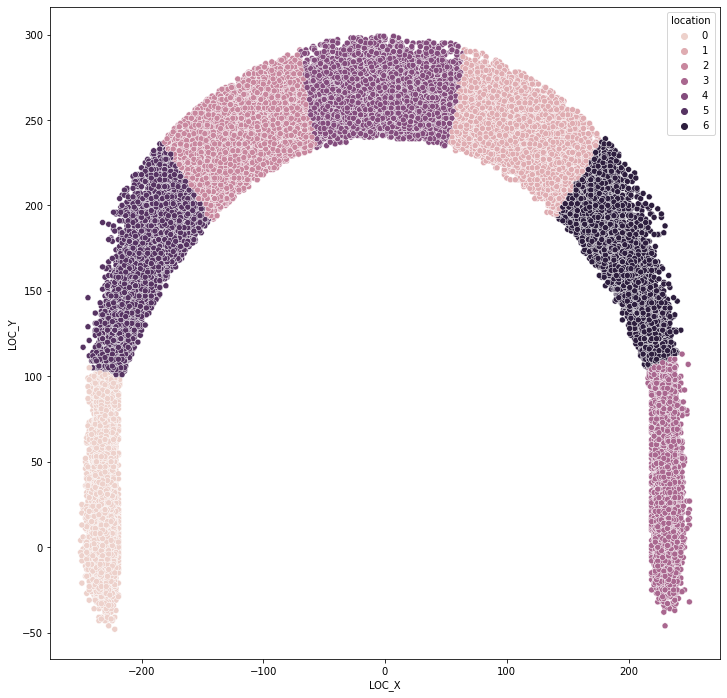

In [5]:
df_shots, df_outlier_3pt = acquire.create_3pt_shot_zones(df_shots)

##### *Both dataframes returned properly*

### [1-3 Combined] Test shot acquisition function.

In [6]:
df_shots, df_outlier_3pt = acquire.acquire_shots()

----

### *At this point, we need game_id and player_id for the game we want to analyze.*

In [7]:
df_shots.sample(1)

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,abs_time,zone
169879,Shot Chart Detail,22100574,545,203488,Mike Muscala,1610612760,Oklahoma City Thunder,4,6,54,Missed Shot,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,10,27,1,0,20220105,MIN,OKC,2466,NaN


In [8]:
game_id = '0022100508'
player_id = 1628960

##### IMPORTANT NOTE: For df_base, game_id needs to be string with two leading zeros!

### 4. Creating the base for the player-game dataframe.

In [9]:
df_base = acquire.create_base_df(game_id)

##### - Checked and abs_time function inside this game acquirer worked properly.
##### - For rotation data, player_id needs to be an integer.

### 5. Get rotation data

Rotation data used to calculate play time and rest.

In [10]:
df_player_roto_times = acquire.get_player_rotation_data(game_id, player_id)

### 6. Build player-gameline - one of two input dataframes

In [11]:
df_player_game = acquire.build_player_gameline(df_player_roto_times, df_base)

### [4-6 Combined] Putting it all together:

In [12]:
df_player_game = acquire.acquire_player_game(game_id, player_id)

----

### 7. Get the shot info for a single player in a single game.

In [13]:
df_game_shots = acquire.get_player_game_shots(game_id, player_id, df_shots)

### 8. Identify home team for feature adjustments.

In [14]:
df_game_shots_h = acquire.id_home_team(df_game_shots)

### [7-8 Combined] Combine the game shots with the player game dataframe

In [15]:
df_player_game = acquire.player_game(df_game_shots_h, df_player_game)

### 9. Clean Player-Game

In [16]:
df_player_game_target = acquire.clean_game(df_player_game)

### [6-9 Combined] Get player game with target, cleaned

In [17]:
df_player_game_target = acquire.acquire_player_game_target(game_id, player_id, df_shots)

### 10. Getting all 3 pointers for a season for a single player

In [18]:
player_full_name = 'Andre Iguodala'

Cannot run this without scraping.

In [19]:
# df_player_season = acquire.player_season_3pa(player_full_name)

----

### 11. Scrape the 'tome' (all 3 points with features)

Unnecessary to run this

In [20]:
# acquire.the_tome() -> Acquires and combines all steps above to scrape the data from NBA.stats via NBA-API

### 12. Acquire the tome

Ensure all needed .csvs are in the directory:
- league_3pa.csv
- all_last_season_outliers.csv
- all_last_season_shots_3pt_clusters.csv

In [21]:
tome = acquire.get_tome()

### 13. Prep the tome before wrangling (splitting, additional feature creation, encoding categoricals)

In [22]:
tome = acquire.tome_prep()

In [23]:
game_events = df_shots[['GAME_ID','abs_time','GAME_EVENT_ID']]

In [24]:
tome.merge(game_events, how = 'inner', left_on = ('game_id','abs_time'), right_on = ('GAME_ID','abs_time'))

,player,player_id,team,team_id,game_id,home,period,abs_time,play_time,since_rest,loc_x,loc_y,zone,shot_type,score_margin,points,shot_result,GAME_ID,GAME_EVENT_ID
0,Bogdan Bogdanovic,203992,Atlanta Hawks,1610612737,22100014,True,1,226,226.0,226.0,228,64,R Below Break/Corner,Jump Shot,-3,0,Made Shot,22100014,42
1,Bogdan Bogdanovic,203992,Atlanta Hawks,1610612737,22100014,True,1,253,253.0,253.0,91,232,R Above Break,Jump Shot,0,3,Made Shot,22100014,47
2,Bogdan Bogdanovic,203992,Atlanta Hawks,1610612737,22100014,True,3,1580,867.0,140.0,228,69,R Below Break/Corner,Jump Shot,11,6,Made Shot,22100014,362
3,Bogdan Bogdanovic,203992,Atlanta Hawks,1610612737,22100014,True,3,1896,1183.0,456.0,134,210,R Above Break,Jump Shot,18,9,Missed Shot,22100014,433
4,Bogdan Bogdanovic,203992,Atlanta Hawks,1610612737,22100014,True,4,2411,1308.0,19.0,-148,203,Center,Jump Shot,23,9,Missed Shot,22100014,548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84223,Terry Rozier,1626179,Charlotte Hornets,1610612766,22101217,True,3,1470,1069.0,500.0,-210,141,L Above Break,Jump Shot,2,5,Missed Shot,22101217,351
84224,Terry Rozier,1626179,Charlotte Hornets,1610612766,22101217,True,4,2366,1538.0,15.0,-228,31,R Center,Fadeaway Jump Shot,6,9,Made Shot,22101217,565
84225,Terry Rozier,1626179,Charlotte Hornets,1610612766,22101217,True,4,2393,1565.0,42.0,-228,-7,R Center,Fadeaway Jump Shot,9,12,Made Shot,22101217,571
84226,Terry Rozier,1626179,Charlotte Hornets,1610612766,22101217,True,4,2566,1738.0,215.0,-232,1,R Center,Fadeaway Jump Shot,14,28,Made Shot,22101217,603


## II. Location/zone clustering

### 1. Acquire a dataframe with every shot taken in the 2021-2022 regular season.

Note: This will acquire and cache .csv in notebook directory

In [25]:
filename = 'all_last_season_shots.csv'
if os.path.isfile(filename):
    df_all_shots =  pd.read_csv(filename, index_col=0)
else:
    df = pd.DataFrame()
    index = 0
    for player in players_list:
        print(f'\rFetching index {index} of 714', end='')
        df_pl = shotchartdetail.ShotChartDetail(team_id = player[0],
                                                        player_id = player[1],
                                                        season_type_all_star='Regular Season',
                                                        season_nullable='2021-22',
                                                        context_measure_simple = 'FG3A').get_data_frames()
        time.sleep(.5)
        index += 1
        df = pd.concat([df, df_pl[0]])
        df.to_csv(filename)

### 2. Add 3pt cluster into shot dataframe (only for 3pt shots)

We first remove outliers - set up a df with only 3-pointers to find the iqr and use that to determine distance outliers

In [26]:
df_all_shots = df_all_shots.reset_index(drop = True)

In [27]:
df_all_3pt = df_all_shots[df_all_shots.SHOT_TYPE == '3PT Field Goal']

In [28]:
low = df_all_3pt.SHOT_DISTANCE.quantile(.25)
high = df_all_3pt.SHOT_DISTANCE.quantile(.75)
# k = 1.5
add = (high-low) * 1.5
bound = high + add
bound

29.0

In [29]:
df_outlier_3pt = df_all_3pt[df_all_3pt.SHOT_DISTANCE > bound]

In [30]:
df_3pt = df_all_3pt[df_all_3pt.SHOT_DISTANCE <= bound]

In [31]:
df_shots = df_all_shots[df_all_shots.SHOT_DISTANCE <= bound]

### 3. Create clusters using loc_x and lox_y

In [32]:
X = df_3pt[['LOC_X','LOC_Y']]

In [33]:
# Tried with a number of n_clusters as well as used k-elbow technique
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)

clusters = kmeans.predict(X)

In [34]:
df_3pt['3pt_location'] = clusters

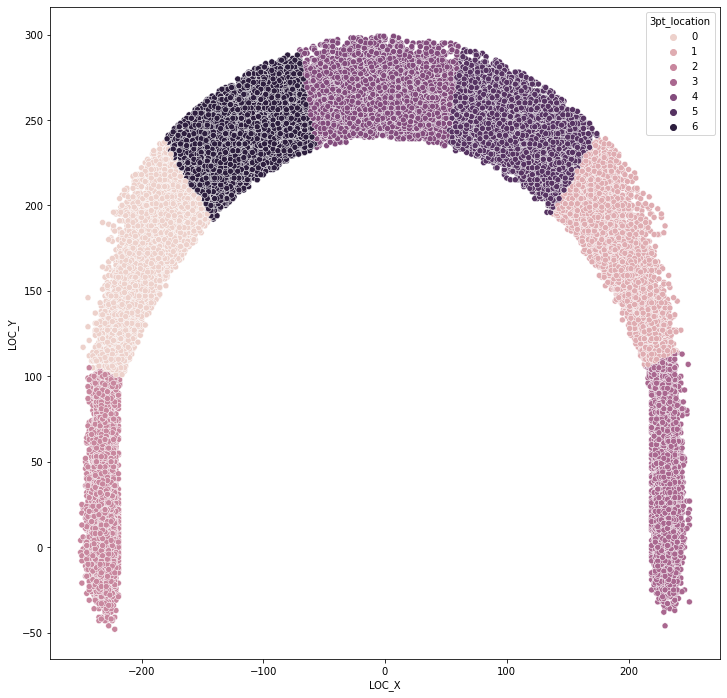

In [35]:
plt.figure(figsize = (12,12))
sns.scatterplot(data =df_3pt, x='LOC_X', y = 'LOC_Y', hue = '3pt_location')
plt.show()

### 4. Change location cluster names to descriptives

In [36]:
df_3pt['3pt_location'] = df_3pt['3pt_location'].map({0: 'R Above Break', 1: 'L Above Break',2:'L Below Break/Corner',3:'R Center',4:'R Below Break/Corner',5:'Center',6:'L Center'})

In [37]:
location_column = df_3pt[['3pt_location']]

### 5. Merge to apply clusters to 3pt shots (all 2pt shots will be NaN)

In [38]:
df_shots = df_shots.merge(location_column, how = 'left', left_index = True, right_index = True)

In [39]:
df_shots.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,3pt_location
0,Shot Chart Detail,22100014,42,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,1,8,14,Made Shot,Jump Shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,23,228,64,1,1,20211021,ATL,DAL,R Center
1,Shot Chart Detail,22100014,47,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,1,7,47,Made Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,24,91,232,1,1,20211021,ATL,DAL,Center
2,Shot Chart Detail,22100014,305,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,2,1,44,Missed Shot,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,6,79,1,0,20211021,ATL,DAL,NaN
3,Shot Chart Detail,22100014,362,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,3,9,40,Made Shot,Jump Shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,23,228,69,1,1,20211021,ATL,DAL,R Center
4,Shot Chart Detail,22100014,433,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,3,4,24,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,24,134,210,1,0,20211021,ATL,DAL,Center
